<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L27-GraphNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Machine Learning



In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\placeholder.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\scatter.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\segment_coo.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\segment_csr.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\testing.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\utils.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\__init__.py -> build\lib.win-amd64-cpython-312\torch_scatter
      creating build\lib.win-amd

## Facebook Page-Page dataset

This dataset was introduced by [Rozemberczki et al. in 2019](https://arxiv.org/abs/1909.13021). It was created using the Facebook Graph API in November 2017. In this dataset, each of the 22,470 nodes represents an official Facebook page. Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are created from textual descriptions written by the owners of these pages. Our goal is to classify each node into one of four categories:

- politicians
- companies
- television shows
- governmental organizations.

The Facebook Page-Page dataset is similar to the previous one: it’s a social network with a node classification task. However, there are three major differences with Cora:

The number of nodes is much higher (2,708 versus 22,470)
The dimensionality of the node features decreased dramatically (from 1,433 to 128)
The goal is to classify each node into four categories instead of seven (which is easier since there are fewer options)
The following figure is a visualization of the dataset using Gephi. First, nodes with few connections have been filtered out to improve performance. The size of the remaining nodes depends on their number of connections, and their color indicates the category they belong to. Finally, two layouts have been applied: Fruchterman-Reingold and ForceAtlas2.

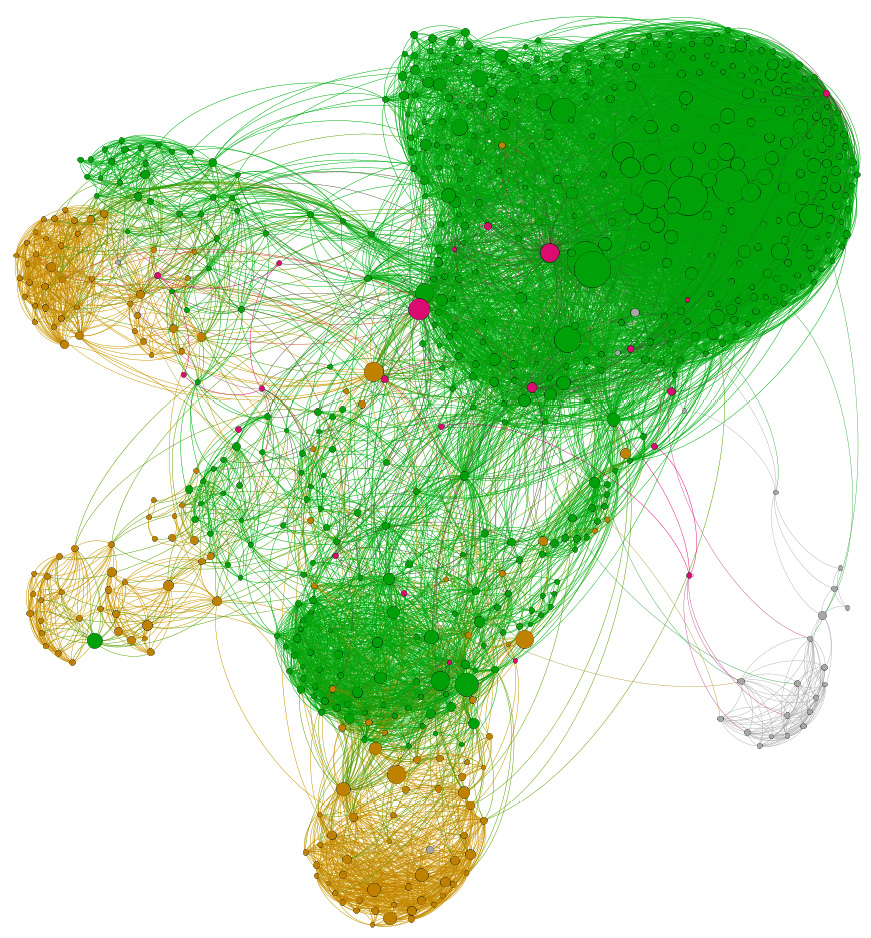

### Load dataset

In [3]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

c:\Users\angi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


In [4]:
data.train_mask[34]

34

## Visualizing the graph

In [5]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [6]:
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")

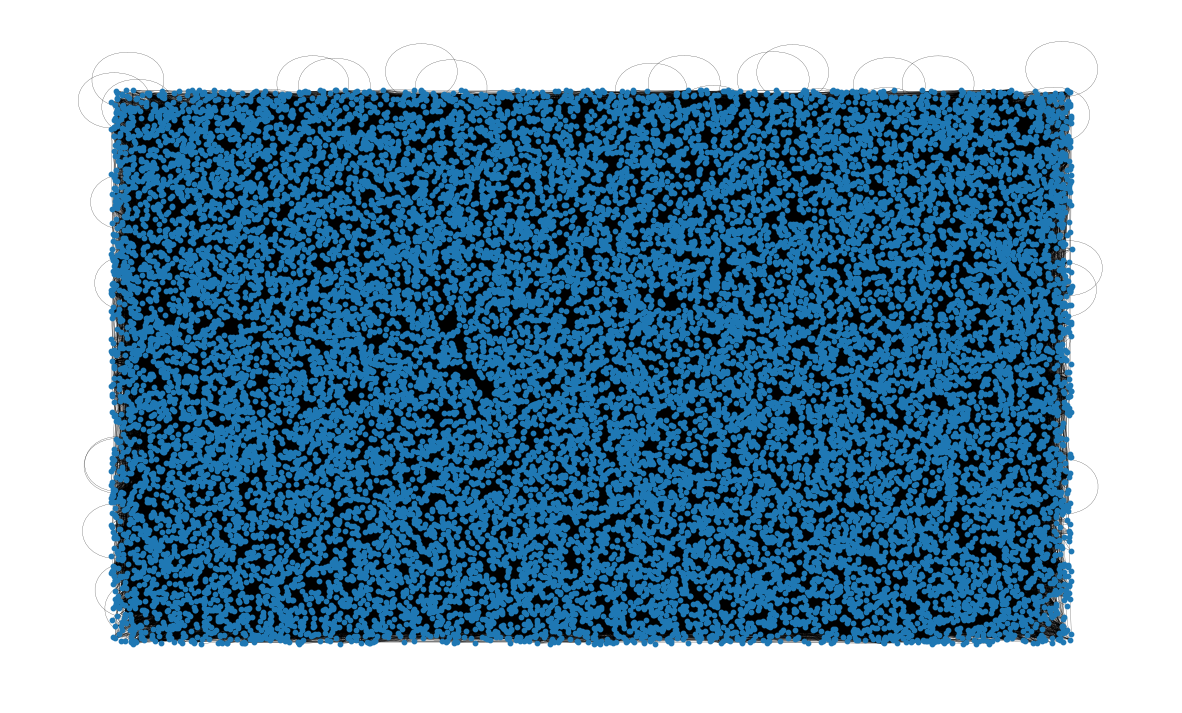

In [7]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

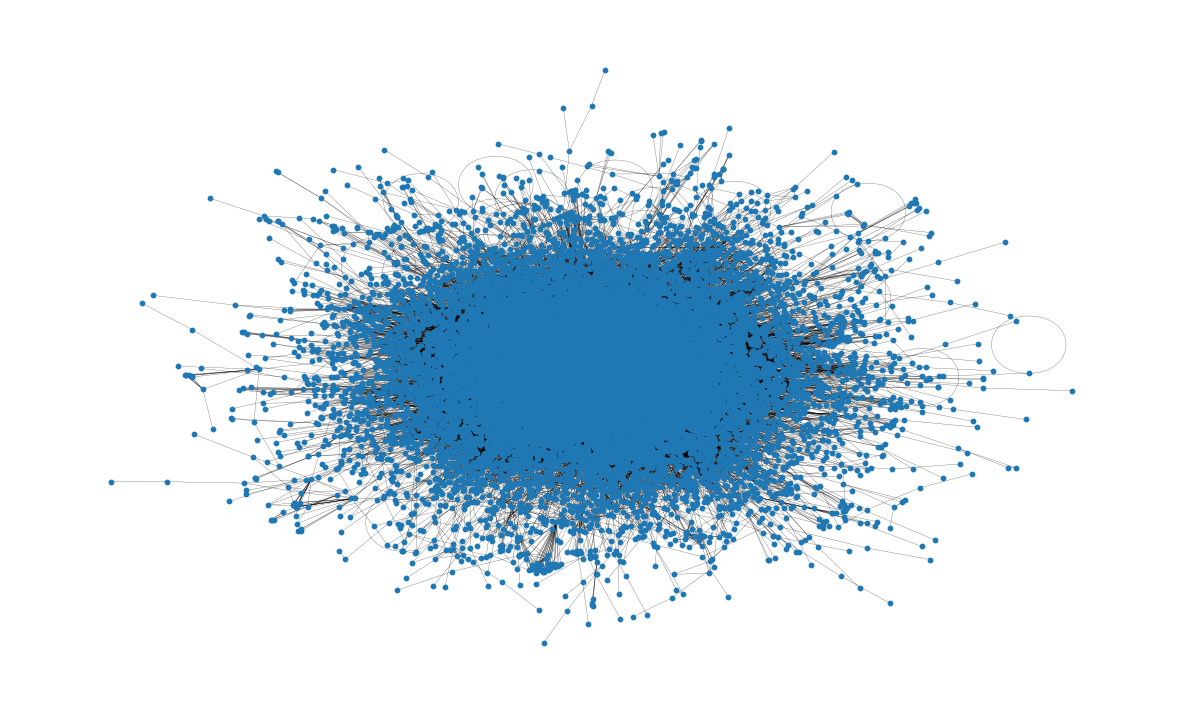

In [8]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Split dataset

In [9]:
# Dataset
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

In [40]:
# Fijar la semilla
torch.manual_seed(42)

In [41]:
# Filtering at least three connections
edge_index_list_filtered = edge_index_list.groupby("start_node").filter(lambda x: len(x) > 3)
edge_index_list_filtered.head()

,start_node,end_node
1,18427,0
2,1,21708
3,21708,1
4,1,22208
5,22208,1


In [11]:
G = nx.from_pandas_edgelist(edge_index_list_filtered, "start_node", "end_node")

 G se convierte en un grafo en el que cada fila del DataFrame representa una arista entre dos nodos. Este grafo G conserva solo los nodos y aristas que cumplen con el criterio de tener al menos tres conexiones, lo cual puede ser útil para analizar la estructura de conexiones significativas.

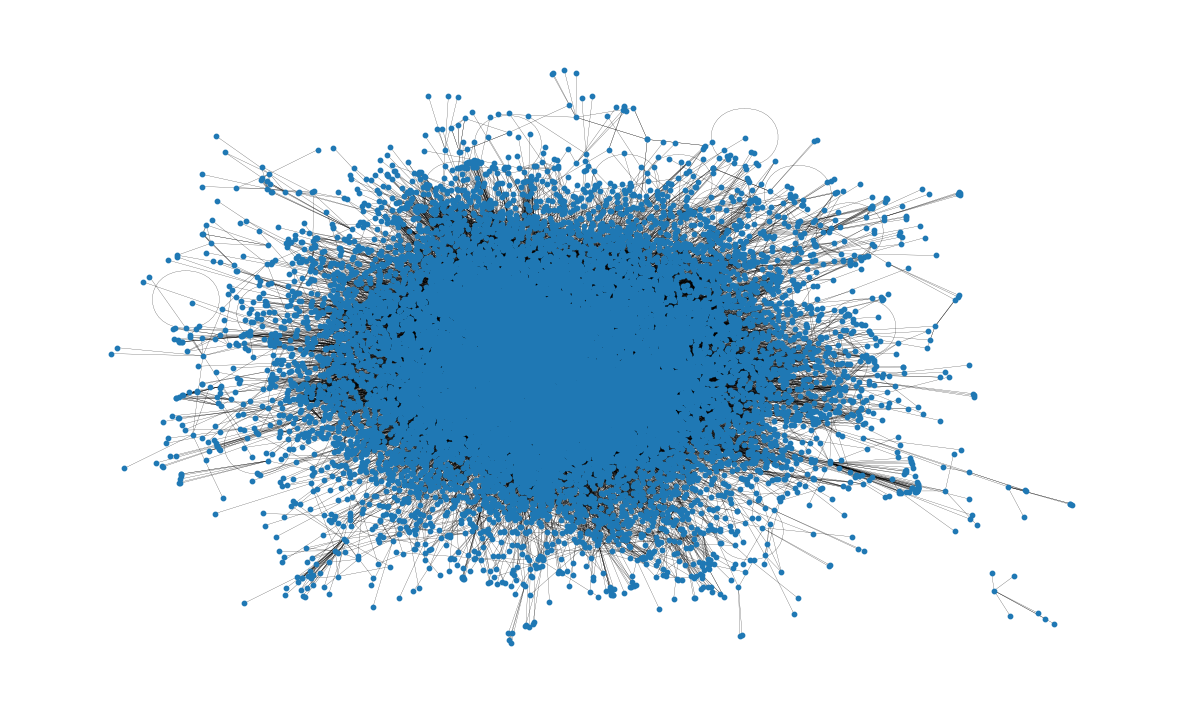

In [19]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Build Adjacency Matrix

In [20]:
# Adjacency matrix

from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency)) # A 2-D tensor with ones on the diagonal and zeros elsewhere
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [21]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [22]:
class SparseLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

### Build MLP class

In [44]:
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.215140,-0.375903,-0.223836,0
1,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.234818,-0.223700,-0.284379,-0.197935,-0.147256,-0.255755,-0.215140,-0.364134,-0.128634,2
2,-0.262576,-0.265053,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.210461,-0.25101,3.222161,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.215140,-0.375903,-0.223836,1
3,-0.246378,-0.276483,-0.241991,-0.299327,-0.299159,-0.270681,-0.307051,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.265534,-0.080353,-0.209509,-0.250560,-0.180260,-0.375903,-0.223836,2
4,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.175312,-0.272613,-0.224216,-0.181153,-0.255755,-0.215140,-0.370639,-0.223836,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22465,-0.262576,-0.276483,-0.262350,-0.296955,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.196685,-0.370115,-0.223836,3
22466,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.221643,-0.284379,-0.224216,-0.209509,-0.255755,-0.215140,-0.375903,-0.223836,1
22467,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.146793,-0.255755,-0.180389,-0.372097,-0.222613,2
22468,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307668,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.252456,-0.215140,-0.375903,-0.218148,1


In [45]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [47]:
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [48]:
# Create MLP model
mlp = MLP(dataset.num_features, 60, dataset.num_classes)
print(mlp)

# Train
mlp.fit(data, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=128, out_features=60, bias=True)
  (linear2): Linear(in_features=60, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.390 | Train Acc: 26.02% | Val Loss: 1.39 | Val Acc: 25.68%
Epoch  20 | Train Loss: 0.586 | Train Acc: 76.96% | Val Loss: 0.63 | Val Acc: 76.28%
Epoch  40 | Train Loss: 0.519 | Train Acc: 79.13% | Val Loss: 0.61 | Val Acc: 75.83%
Epoch  60 | Train Loss: 0.475 | Train Acc: 81.43% | Val Loss: 0.60 | Val Acc: 76.68%
Epoch  80 | Train Loss: 0.437 | Train Acc: 83.06% | Val Loss: 0.60 | Val Acc: 77.48%
Epoch 100 | Train Loss: 0.409 | Train Acc: 84.32% | Val Loss: 0.62 | Val Acc: 76.55%

MLP test accuracy: 76.77%


### Build GNN class

In [49]:
class GNN(torch.nn.Module):
    """Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = SparseLayer(dim_in, dim_h)
        self.gnn2 = SparseLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)
    
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [50]:
# Create GNN model
gnn = GNN(dataset.num_features, 30, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

GNN(
  (gnn1): SparseLayer(
    (linear): Linear(in_features=128, out_features=30, bias=False)
  )
  (gnn2): SparseLayer(
    (linear): Linear(in_features=30, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 123.875 | Train Acc: 25.63% | Val Loss: 117.99 | Val Acc: 24.52%
Epoch  20 | Train Loss: 8.302 | Train Acc: 82.43% | Val Loss: 11.64 | Val Acc: 81.80%
Epoch  40 | Train Loss: 4.446 | Train Acc: 84.28% | Val Loss: 6.84 | Val Acc: 84.42%
Epoch  60 | Train Loss: 3.875 | Train Acc: 84.13% | Val Loss: 5.79 | Val Acc: 83.93%
Epoch  80 | Train Loss: 1.408 | Train Acc: 86.21% | Val Loss: 2.22 | Val Acc: 85.76%
Epoch 100 | Train Loss: 1.433 | Train Acc: 85.28% | Val Loss: 2.24 | Val Acc: 84.65%

GNN test accuracy: 85.22%


## Otro modelo GNN

In [29]:
from torch_geometric.nn import GATv2Conv
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.utils.data import random_split

In [30]:
class EnhancedGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)  # Segunda capa con GAT

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(F.relu(self.gat1(x, edge_index)), p=0.5, training=self.training)
        x = F.dropout(F.relu(self.gat2(x, edge_index)), p=0.5, training=self.training)
        return F.log_softmax(x, dim=1)

In [31]:
enhanced_gnn = EnhancedGNN(dataset.num_features, 64, dataset.num_classes, heads=4)
print(enhanced_gnn)


# Test
# acc = enhanced_gnn.test(data)
# print(f'\nEnhancedGNN test accuracy: {acc*100:.2f}%')

with torch.no_grad():
    enhanced_gnn.eval()  # Cambia el modelo a modo de evaluación
    output = enhanced_gnn(data)  # Realiza una pasada hacia adelante
    _, predicted = output.max(1)
    correct = predicted.eq(data.y).sum().item()
    accuracy = correct / len(data.y)  # Calcula la precisión (accuracy)

print(f'Accuracy: {accuracy * 100:.2f}%')

EnhancedGNN(
  (gat1): GATv2Conv(128, 64, heads=4)
  (gat2): GATv2Conv(256, 4, heads=1)
)
Accuracy: 32.86%


### Run models and compare

GNN test accuracy: 85.22% Mejor modelo

MLP test accuracy: 76.77%

### Split dataset
User a pytorch random split and debug model classes...

### GNN class with random_split

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.utils.data import random_split

# Definir el modelo GNN
class GNN(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_units)
        self.conv2 = GCNConv(hidden_units, out_features)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Fijar la semilla
torch.manual_seed(42)

# Preparar el dataset y dividirlo con random_split
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Definir el tamaño de cada subconjunto
num_nodes = data.num_nodes
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)
test_size = num_nodes - train_size - val_size

# Realizar la división usando random_split
indices = torch.randperm(num_nodes)
train_indices, val_indices, test_indices = torch.split(indices, [train_size, val_size, test_size])

# Crear máscaras de entrenamiento, validación y prueba
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True

data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask[val_indices] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# Inicializar el modelo, el criterio de pérdida y el optimizador
gnn = GNN(dataset.num_features, hidden_units=64, out_features=dataset.num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters(), lr=0.01)

# Función de entrenamiento
def train(model1, data):
    model1.train()
    optimizer.zero_grad()
    out = model1(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Función de evaluación
def evaluate(model1, data, mask):
    model1.eval()
    with torch.no_grad():
        out = model1(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()
    return accuracy

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(gnn, data)
    train_acc = evaluate(gnn, data, data.train_mask)
    val_acc = evaluate(gnn, data, data.val_mask)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

# Evaluar el modelo final en el conjunto de prueba
test_acc = evaluate(gnn, data, data.test_mask)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")


Epoch 1/100, Loss: 1.4610, Train Acc: 57.12%, Val Acc: 56.56%
Epoch 2/100, Loss: 1.1492, Train Acc: 66.45%, Val Acc: 66.58%
Epoch 3/100, Loss: 0.9417, Train Acc: 71.65%, Val Acc: 71.16%
Epoch 4/100, Loss: 0.8029, Train Acc: 75.03%, Val Acc: 74.59%
Epoch 5/100, Loss: 0.7055, Train Acc: 77.45%, Val Acc: 77.08%
Epoch 6/100, Loss: 0.6319, Train Acc: 79.73%, Val Acc: 78.68%
Epoch 7/100, Loss: 0.5737, Train Acc: 81.62%, Val Acc: 80.73%
Epoch 8/100, Loss: 0.5268, Train Acc: 83.47%, Val Acc: 82.51%
Epoch 9/100, Loss: 0.4891, Train Acc: 84.49%, Val Acc: 83.67%
Epoch 10/100, Loss: 0.4586, Train Acc: 85.50%, Val Acc: 84.51%
Epoch 11/100, Loss: 0.4335, Train Acc: 86.30%, Val Acc: 85.58%
Epoch 12/100, Loss: 0.4123, Train Acc: 86.82%, Val Acc: 86.34%
Epoch 13/100, Loss: 0.3944, Train Acc: 87.36%, Val Acc: 86.56%
Epoch 14/100, Loss: 0.3790, Train Acc: 87.81%, Val Acc: 87.09%
Epoch 15/100, Loss: 0.3658, Train Acc: 88.23%, Val Acc: 87.72%
Epoch 16/100, Loss: 0.3543, Train Acc: 88.43%, Val Acc: 87.98%
E

In [51]:
# Imprimir tamaños de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de validación: {val_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

Tamaño del conjunto de entrenamiento: 17976
Tamaño del conjunto de validación: 2247
Tamaño del conjunto de prueba: 2247


In [52]:
import torch.nn as nn
import torch.optim as optim

### Build MLP class

In [55]:
# MLP class with random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch_geometric.data import Data

# Definir la clase MLP
class MLP(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_units)
        self.fc2 = nn.Linear(hidden_units, out_features)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)  # Para clasificación multiclase

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

# Fijar la semilla
torch.manual_seed(42)

# Preparar el dataset y dividirlo usando random_split
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Definir el tamaño de cada subconjunto
num_nodes = data.num_nodes
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)
test_size = num_nodes - train_size - val_size

# Realizar la división usando random_split
indices = torch.randperm(num_nodes)
train_indices, val_indices, test_indices = torch.split(indices, [train_size, val_size, test_size])

# Crear máscaras de entrenamiento, validación y prueba
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True

data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask[val_indices] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# Inicializar el modelo, el criterio de pérdida y el optimizador
input_dim = dataset.num_features
hidden_dim = 64
output_dim = dataset.num_classes

model2 = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Función de entrenamiento
def train(model2, data):
    model2.train()
    optimizer.zero_grad()
    out = model2(data.x)  # Solo pasa los features de nodos al MLP
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Función de evaluación
def evaluate(model2, data, mask):
    model2.eval()
    with torch.no_grad():
        out = model2(data.x)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()
    return accuracy

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(model2, data)
    train_acc = evaluate(model2, data, data.train_mask)
    val_acc = evaluate(model2, data, data.val_mask)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

# Evaluación final en el conjunto de prueba
test_acc = evaluate(model2, data, data.test_mask)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")


Epoch 1/100, Loss: 1.3975, Train Acc: 20.79%, Val Acc: 19.98%
Epoch 2/100, Loss: 1.3920, Train Acc: 24.87%, Val Acc: 23.72%
Epoch 3/100, Loss: 1.3864, Train Acc: 29.76%, Val Acc: 28.04%
Epoch 4/100, Loss: 1.3808, Train Acc: 34.86%, Val Acc: 33.47%
Epoch 5/100, Loss: 1.3752, Train Acc: 39.45%, Val Acc: 39.03%
Epoch 6/100, Loss: 1.3695, Train Acc: 42.94%, Val Acc: 42.86%
Epoch 7/100, Loss: 1.3637, Train Acc: 45.47%, Val Acc: 45.08%
Epoch 8/100, Loss: 1.3579, Train Acc: 47.23%, Val Acc: 46.15%
Epoch 9/100, Loss: 1.3520, Train Acc: 48.21%, Val Acc: 47.26%
Epoch 10/100, Loss: 1.3460, Train Acc: 48.96%, Val Acc: 48.15%
Epoch 11/100, Loss: 1.3400, Train Acc: 49.50%, Val Acc: 48.78%
Epoch 12/100, Loss: 1.3339, Train Acc: 49.69%, Val Acc: 49.13%
Epoch 13/100, Loss: 1.3277, Train Acc: 49.98%, Val Acc: 49.22%
Epoch 14/100, Loss: 1.3215, Train Acc: 50.27%, Val Acc: 49.49%
Epoch 15/100, Loss: 1.3152, Train Acc: 50.48%, Val Acc: 49.80%
Epoch 16/100, Loss: 1.3088, Train Acc: 50.61%, Val Acc: 49.80%
E

### Run and compare models

GNN test accuracy: 93.77% Mejor modelo

MLP test accuracy: 73.16%